<a href="https://colab.research.google.com/github/vanesajc2/Proyecto_DDPG/blob/main/ddpg__mountaincarcountinuous_v0_rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problema Mountain Car Countinuous resuelto con el algoritmo DDPG**

Ejemplo utilizando el entorno MountainCarContinuous-v0 de OpenAI Gym. Este es un ejercicio basado en el paper de Lillicrap (2015) basado en el codigo de Kyunghwan Kim.

![MountainContinuous](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)


In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install gymnasium==1.0.0

T. P. Lillicrap et al., "Control continuo con aprendizaje de refuerzo profundo". Preimpresión de arXiv arXiv:1509.02971, 2015.

El algoritmo Deep Q Network (DQN) (Mnih et al., 2013; 2015) combina los avances en el aprendizaje profundo con el aprendizaje de refuerzo. Sin embargo, si bien DQN resuelve problemas con espacios de observación de alta dimensión, solo puede manejar espacios de acción discretos y de baja dimensión debido al uso de políticas voraces. Para el aprendizaje en espacios de acción continuos y de alta dimensión, los autores combinan el enfoque actor-crítico con conocimientos del éxito reciente de DQN. Deep DPG (DDPG) se basa en el algoritmo de gradiente de política determinista (DPG) (Silver et al., 2014).

### Deterministic policy gradient
El algoritmo DPG mantiene una función de actor parametrizada
$\mu(s|\theta^{\mu})$ que especifica la política actual mediante la asignación determinista de estados a una acción específica.

El crítico $Q(s, a)$ se aprende utilizando la ecuación de Bellman como en el aprendizaje Q. El actor se actualiza siguiendo la aplicación de la regla de la cadena al retorno esperado de la distribución inicial  $J$ con respecto a los parámetros del actor.

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$


### Buffer de reproducción
Un desafío al usar redes neuronales para el aprendizaje de refuerzo es que la mayoría de los algoritmos de optimización suponen que **las muestras están distribuidas de manera independiente e idéntica**. Cuando las muestras se generan a partir de la exploración secuencial en un entorno, esta suposición ya no se cumple. Los autores utilizaron un **buffer de reproducción** para abordar estos problemas. Las transiciones se muestrearon del entorno de acuerdo con la política de exploración y la tupla $(s_t, a_t, r_t, s_{t+1})$ que se almacenó en el buffer de reproducción. En cada paso de tiempo, el actor y el crítico se actualizan mediante el muestreo de un minibatch de manera uniforme del buffer. Esto permite beneficiarse del aprendizaje a través de un conjunto de transiciones **no correlacionadas**.


### Actualización suave de la red objetivo
Dado que la red $(Q(s,a|\theta^Q)$ que se está actualizando también se utiliza para calcular el valor objetivo, la actualización de Q es propensa a divergencias. Para evitar esto, los autores utilizan **la red objetivo** como DQN, pero modificada para actor-crítico y utilizando **actualizaciones suaves de objetivo**. Las redes objetivo se crean copiando las redes de actor y crítico, $Q'(s,a|\theta^{Q'})$ y $\mu'(s|\theta^{\mu`})$ respectivamente, que se utilizan para calcular los valores objetivo. Los pesos de estas redes objetivo se actualizan luego haciendo que rastreen lentamente las redes aprendidas:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

Mejora en gran medida la estabilidad del aprendizaje.


### Exploración del espacio de acción continua
Una ventaja de las políticas fuera de línea Los algoritmos como DDPG permiten tratar el problema de la exploración independientemente del algoritmo de aprendizaje. Los autores construyen una política de exploración $\mu'$ añadiendo ruido muestreado de un proceso de ruido $\mathcal{N}$ a la política del actor

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ puede elegirse para adaptarse al entorno. Los autores utilizaron el **proceso Ornstein-Uhlenbeck** para generar una exploración correlacionada temporalmente.


# Importar modulos

In [ ]:
import copy
import random
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Buffer de reproducción
Normalmente, las personas implementan buffers de reproducción con una de las siguientes tres estructuras de datos:

- collections.deque
- list
- numpy.ndarray

**deque** es muy fácil de manejar una vez que inicializa su longitud máxima (p. ej., deque(maxlen=buffer_size)). Sin embargo, la operación de indexación de deque se vuelve terriblemente lenta a medida que crece porque es una [lista internamente doblemente enlazada](https://wiki.python.org/moin/TimeComplexity#collections.deque). Por otro lado, **list** es una matriz, por lo que es relativamente más rápida que deque cuando muestrea lotes en cada paso. Su costo amortizado de Obtener elemento es [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Por último, pero no menos importante, veamos **numpy.ndarray**. numpy.ndarray es incluso más rápido que list debido al hecho de que es [una matriz homogénea de elementos de tamaño fijo](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), por lo que puede obtener los beneficios de la [localidad de referencia](https://en.wikipedia.org/wiki/Locality_of_reference), mientras que list es una matriz de punteros a objetos, incluso cuando todos ellos son del mismo tipo.

Aquí, vamos a implementar un búfer de reproducción utilizando numpy.ndarray.

Reference:
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, act_dim: int, size: int, batch_size: int = 32):
        """Initializate."""
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros([size], dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ):
        """Store the transition in buffer."""
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def __len__(self) -> int:
        return self.size

## Ruido de OU
El proceso **Ornstein-Uhlenbeck** genera una exploración correlacionada temporalmente y se enfrenta de manera eficaz a los problemas de control físico de la inercia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Referencia:
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [ ]:
class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(self, size: int, mu: float = 0.0, theta: float = 0.15, sigma: float = 0.2):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array(
            [random.random() for _ in range(len(x))]
        )
        self.state = x + dx
        return self.state

# **Red**

Vamos a utilizar dos redes separadas para el actor y el crítico.

La red del actor tiene tres capas completamente conectadas y tres funciones de no linealidad, ReLU para las capas ocultas y tanh para la capa de salida.

Por otro lado, la red del crítico tiene tres capas completamente conectadas, pero utiliza dos funciones de activación para las capas ocultas ReLU. Además, los tamaños de entrada de la red del crítico son la suma de los tamaños de los estados y los tamaños de las acciones.

Una cosa a tener en cuenta es que inicializamos los pesos y sesgos de la capa final para que se distribuyan de manera uniforme.

In [ ]:
HIDDEN_LAYERS_ACTOR = 128
HIDDEN_LAYERS_CRITIC = 256
class Actor(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, init_w: float = 3e-3):
        """Initialize."""
        super(Actor, self).__init__()

        self.bn1 = nn.LayerNorm(HIDDEN_LAYERS_ACTOR)
        self.bn2 = nn.LayerNorm(HIDDEN_LAYERS_ACTOR)

        self.hidden1 = nn.Linear(in_dim, 128)
        self.hidden2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, out_dim)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = F.relu (self.bn1(self.hidden1(state)))#
        x = F.relu(self.bn2(self.hidden2(x)))#

       # x = F.relu (self.hidden1(state))#
        #x = F.relu(self.hidden2(x))#
        action = self.out(x).tanh()

        return action


class Critic(nn.Module):
    def __init__(
        self,
        in_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(Critic, self).__init__()

        self.bn1 = nn.BatchNorm1d(HIDDEN_LAYERS_CRITIC)
        self.bn2 = nn.BatchNorm1d(HIDDEN_LAYERS_CRITIC)

        self.hidden1 = nn.Linear(in_dim, 256)
        self.hidden2 = nn.Linear(256, 256)
        self.out = nn.Linear(256, 1)

        self.out.weight.data.uniform_(-init_w, init_w)
        self.out.bias.data.uniform_(-init_w, init_w)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.bn1(self.hidden1(x)))
        x = F.relu(self.bn2(self.hidden2(x)))

       # x = F.relu(self.hidden1(x))
       # x = F.relu(self.hidden2(x))
        value = self.out(x)

        return value

## Agente DDPG
## A continuación se incluye un resumen de la clase DDPGAgent.

| Método | Nota |
|--- |--- |
|select_action | selecciona una acción del estado de entrada. |
|step | realiza una acción y devuelve la respuesta del entorno. |
|update_model | actualiza el modelo por descenso de gradiente. |
|train | entrena al agente durante num_frames. |
|test | prueba al agente (1 episodio). |
|\_target_soft_update| actualización suave del modelo local al modelo de destino.|
|\_plot | traza el progreso del entrenamiento. |

In [ ]:
class DDPGAgent:
    """DDPGAgent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporary storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
        seed (int): random seed
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        seed: int = 777,
    ):
        """Initialize."""
        obs_dim = env.observation_space.shape[0]
        action_dim =env.action_space.shape[0]

        self.env = env
        self.memory = ReplayBuffer(obs_dim, action_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.seed = seed

        # noise
        self.noise = OUNoise(
            action_dim,
            theta=ou_noise_theta,
            sigma=ou_noise_sigma,
        )

        # device: cpu / gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)

        # networks
        self.actor = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target = Actor(obs_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())

        self.critic = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target = Critic(obs_dim + action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        # optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # transition to store in memory
        self.transition = list()

        # total steps count
        self.total_step = 0

        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # if initial random action should be conducted
        if self.total_step < self.initial_random_steps and not self.is_test:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = (
                self.actor(torch.FloatTensor(state).to(self.device)).detach().cpu().numpy()
            )

        # add noise for exploration during training
        if not self.is_test:
            noise = self.noise.sample()
            selected_action = np.clip(selected_action + noise, -1.0, 1.0)

        self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        device = self.device  # for shortening the following lines

        samples = self.memory.sample_batch()
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.FloatTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        masks = 1 - done
        next_action = self.actor_target(next_state)
        next_value = self.critic_target(next_state, next_action)
        curr_return = reward + self.gamma * next_value * masks

        # train critic
        values = self.critic(state, action)
        critic_loss = F.mse_loss(values, curr_return)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # train actor
        actor_loss = -self.critic(state, self.actor(state)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # target update
        self._target_soft_update()

        return actor_loss.data, critic_loss.data

    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0

        for self.total_step in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                scores.append(score)
                score = 0

           # Stop condition
            mean_s=np.mean(scores[-10:])
            if mean_s >= 70.0:
                break


            # if training is ready
            if len(self.memory) >= self.batch_size and self.total_step > self.initial_random_steps:
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss.cpu().numpy())
                critic_losses.append(critic_loss.cpu().numpy())

            # plotting
            if self.total_step % plotting_interval == 0:
                self._plot(
                    self.total_step,
                    scores,
                    actor_losses,
                    critic_losses,
                )

        self.env.close()

    def test(self, video_folder: str):
        """Test the agent."""
        self.is_test = True

        tmp_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        self.env = tmp_env

    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        tau = self.tau

        for t_param, l_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

        for t_param, l_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            t_param.data.copy_(tau * l_param.data + (1.0 - tau) * t_param.data)

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
    ):
        """Plot the training progresses."""

        def subplot(loc: int, title: str, values: List[float]):
            plt.subplot(loc)
            plt.title(title)
            plt.plot(values)

        subplot_params = [
            (131, f"frame {frame_idx}. score: {np.mean(scores[-10:])}", scores),
            (132, "actor_loss", actor_losses),
            (133, "critic_loss", critic_losses),
        ]

        clear_output(True)
        plt.figure(figsize=(30, 5))
        for loc, title, values in subplot_params:
            subplot(loc, title, values)
        plt.show()

## Entorno
*ActionNormalizer* es una clase contenedora de acciones para normalizar los valores de las acciones dentro del rango (-1, 1). Gracias a esta clase, podemos hacer que el agente simplemente seleccione valores de acción dentro del rango centrado en cero (-1, 1).

In [ ]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = action * scale_factor + reloc_factor
        action = np.clip(action, low, high)

        return action

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high

        scale_factor = (high - low) / 2
        reloc_factor = high - scale_factor

        action = (action - reloc_factor) / scale_factor
        action = np.clip(action, -1.0, 1.0)

        return action

Se puede ver [el link](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) de MountainCarContinuous-v0 desde el repositorio de Gym.


In [ ]:
env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array")
#env = ActionNormalizer(env)

En este caso se utiliza BatchNorm1d (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) la cual aplica normalización por lotes sobre una entrada 2D o 3D. (Incluido tanto en Actor y Critic)

In [ ]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])
state_dim, action_dim, max_action

(2, 1, 1.0)

Establecer semilla aleatoria

In [ ]:
def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True


seed = 777
random.seed(seed)
np.random.seed(seed)
seed_torch(seed)

In [ ]:
# parameters
num_frames =100000#
memory_size = 100000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

agent = DDPGAgent(
    env,
    memory_size,
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps,
    seed=seed,
)

cuda


Train

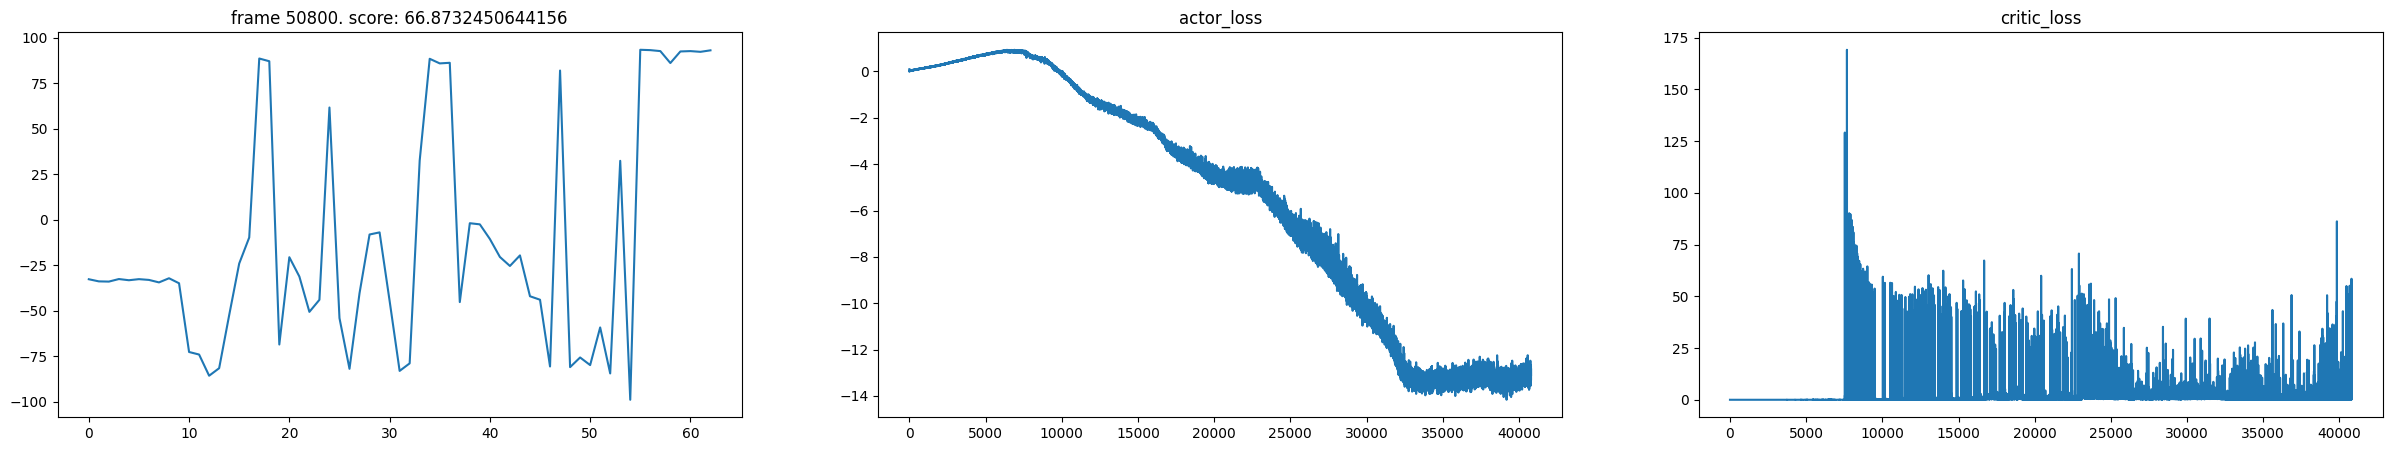

In [ ]:
agent.train(num_frames)#

Test

In [ ]:
# test
video_folder = "videos/ddpg"
agent.test(video_folder=video_folder)

score:  93.26992540617682


Render

In [ ]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(
        HTML(
            data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(
                encoded.decode("ascii")
            )
        )
    )


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))#"*.mp4"
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/ddpg/rl-video-episode-0.mp4
